In [1]:
# Enable importing of utilities.
import sys
import os
sys.path.append(os.environ.get('NOTEBOOK_ROOT'))

# ARDC Training: Python Notebooks
Task-C: Fractional Cover (FC) and Spectral Indices (NDBI and NDVI)

> ### Import the Datacube Configuration

In [2]:
import datacube
import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()
dc = datacube.Datacube(app = 'ardc_task_c')
api.dc = dc

>### Browse the available Data Cubes   

In [3]:
list_of_products = dc.list_products()
netCDF_products = list_of_products[list_of_products['format'] == 'NetCDF']
netCDF_products

,name,description,format,platform,lat,creation_time,time,label,lon,product_type,instrument,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,,,,,,
13,ls7_ledaps_ghana,Landsat 7 USGS Collection 1 Higher Level SR sc...,NetCDF,LANDSAT_7,None,None,None,None,None,LEDAPS,ETM,EPSG:4326,"(-0.000269494585236, 0.000269494585236)","(0.943231048326, 0.943231048326)","(latitude, longitude)"
17,ls7_ledaps_kenya,Landsat 7 USGS Collection 1 Higher Level SR sc...,NetCDF,LANDSAT_7,None,None,None,None,None,LEDAPS,ETM,EPSG:4326,"(-0.000269493, 0.000269493)","(0.99981903, 0.99981903)","(latitude, longitude)"
18,ls7_ledaps_senegal,Landsat 7 USGS Collection 1 Higher Level SR sc...,NetCDF,LANDSAT_7,None,None,None,None,None,LEDAPS,ETM,EPSG:4326,"(-0.000271152, 0.00027769)","(0.813456, 0.83307)","(latitude, longitude)"
16,ls7_ledaps_sierra_leone,Landsat 7 USGS Collection 1 Higher Level SR sc...,NetCDF,LANDSAT_7,None,None,None,None,None,LEDAPS,ETM,EPSG:4326,"(-0.000269494585236, 0.000269494585236)","(0.943231048326, 0.943231048326)","(latitude, longitude)"
19,ls7_ledaps_tanzania,Landsat 7 USGS Collection 1 Higher Level SR sc...,NetCDF,LANDSAT_7,None,None,None,None,None,LEDAPS,ETM,EPSG:4326,"(-0.000271277688070265, 0.000271139577954979)","(0.999929558226998, 0.999962763497961)","(latitude, longitude)"
31,ls7_ledaps_vietnam,Landsat 7 USGS Collection 1 Higher Level SR sc...,NetCDF,LANDSAT_7,None,None,None,None,None,LEDAPS,ETM,EPSG:4326,"(-0.000269494585236, 0.000269494585236)","(0.943231048326, 0.943231048326)","(latitude, longitude)"
9,ls8_lasrc_ghana,Landsat 8 USGS Collection 1 Higher Level SR sc...,NetCDF,LANDSAT_8,None,None,None,None,None,LaSRC,OLI_TIRS,EPSG:4326,"(-0.000269494585236, 0.000269494585236)","(0.943231048326, 0.943231048326)","(latitude, longitude)"
10,ls8_lasrc_kenya,Landsat 8 USGS Collection 1 Higher Level SR sc...,NetCDF,LANDSAT_8,None,None,None,None,None,LaSRC,OLI_TIRS,EPSG:4326,"(-0.000271309115317046, 0.00026957992707863)","(0.999502780827996, 0.999602369607559)","(latitude, longitude)"
11,ls8_lasrc_senegal,Landsat 8 USGS Collection 1 Higher Level SR sc...,NetCDF,LANDSAT_8,None,None,None,None,None,LaSRC,OLI_TIRS,EPSG:4326,"(-0.000271152, 0.00027769)","(0.813456, 0.83307)","(latitude, longitude)"


>### Pick a product  
>Use the platform and product names from the previous block to select a Data Cube.  

In [4]:
# Change the data platform and data cube here

platform = "LANDSAT_7"
# platform = "LANDSAT_8"

# product = "ls7_ledaps_ghana"
# product = "ls7_ledaps_kenya"
# product = "ls7_ledaps_senegal"
# product = "ls7_ledaps_sierra_leone"
# product = "ls7_ledaps_tanzania"
product = "ls7_ledaps_vietnam" 

> #### Display Latitude-Longitude and Time Bounds of the Data Cube

In [5]:
from utils.data_cube_utilities.dc_time import _n64_to_datetime, dt_to_str

extents = api.get_full_dataset_extent(platform = platform, product = product, measurements=[])

latitude_extents = (min(extents['latitude'].values),max(extents['latitude'].values))
longitude_extents = (min(extents['longitude'].values),max(extents['longitude'].values))
time_extents = (min(extents['time'].values),max(extents['time'].values))

print("Latitude Extents:", latitude_extents)
print("Longitude Extents:", longitude_extents)
print("Time Extents:", list(map(dt_to_str, map(_n64_to_datetime, time_extents))))

Latitude Extents: (9.176425374578418, 13.964805165051667)
Longitude Extents: (102.40430421277932, 108.93092407802477)
Time Extents: ['1999-09-08', '2016-12-29']


# Visualize Data Cube Region

In [6]:
## The code below renders a map that can be used to orient yourself with the region.
from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude = latitude_extents, longitude = longitude_extents)

> ### Pick a smaller analysis region and display that region
Try to keep your region to less than 0.2-deg x 0.2-deg for rapid processing. You can click on the map above to find the Lat-Lon coordinates of any location. You will want to identify a region with an urban aree or some known vegetation. Pick a time window of a few months to a year so we can pick out some clear pixels.

In [7]:
## Vietnam - Central Lam Dong Province ##
longitude_extents = (105.2, 105.3)
latitude_extents  = (11.25, 11.35)

time_extents = ('2015-01-01', '2015-12-31')

In [8]:
display_map(latitude = latitude_extents, longitude = longitude_extents)

## Load the dataset and the required spectral bands or other parameters
After loading, you will view the Xarray dataset. Notice the dimensions represent the number of pixels in your latitude and longitude dimension as well as the number of time slices (time) in your time series.

In [9]:
landsat_dataset = dc.load(latitude = latitude_extents,
                          longitude = longitude_extents,
                          platform = platform,
                          time = time_extents,
                          product = product,
                          measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa']) 

In [10]:
landsat_dataset
#view the dimensions and sample content from the cube

<xarray.Dataset>
Dimensions:      (latitude: 372, longitude: 372, time: 16)
Coordinates:
  * time         (time) datetime64[ns] 2015-01-07T03:18:35 ... 2015-12-25T03:...
  * latitude     (latitude) float64 11.35 11.35 11.35 ... 11.25 11.25 11.25
  * longitude    (longitude) float64 105.2 105.2 105.2 ... 105.3 105.3 105.3
    spatial_ref  int32 4326
Data variables:
    red          (time, latitude, longitude) int16 1185 1245 1266 ... 917 1120
    green        (time, latitude, longitude) int16 1295 1295 1316 ... 888 955
    blue         (time, latitude, longitude) int16 1277 1341 1298 ... 862 1034
    nir          (time, latitude, longitude) int16 2741 2605 2558 ... 1867 2001
    swir1        (time, latitude, longitude) int16 1627 1601 1574 ... 1307 1596
    swir2        (time, latitude, longitude) int16 978 978 1006 ... 478 754 1059
    pixel_qa     (time, latitude, longitude) int32 224 224 224 224 ... 66 66 96
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

# Display Example Images  

>#### Single band visualization   
> For a quick inspection, let's look at one image. The code will allow the selection of any band (red, blue, green, nir, swir1, swir2) to produce a grey-scale image. Select the desired acquisition (time slice) in the block below. You can select from 1 to #, where the max value is the number of time slices noted in the block above. Change the comment statements below to select the bands for the first image.

In [11]:
acquisition_number = 0
# select an acquisition number from 0 (first time layer) to "time" using the array limits above

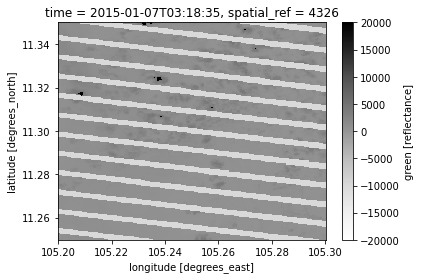

In [12]:
%matplotlib inline
#landsat_dataset.red.isel(time = acquisition_number).plot(cmap = "Greys")
landsat_dataset.green.isel(time = acquisition_number).plot(cmap = "Greys")
#landsat_dataset.blue.isel(time = acquisition_number).plot(cmap = "Greys")
#landsat_dataset.nir.isel(time = acquisition_number).plot(cmap = "Greys")
#landsat_dataset.swir1.isel(time = acquisition_number).plot(cmap = "Greys")
#landsat_dataset.swir2.isel(time = acquisition_number).plot(cmap = "Greys")

>#### Define Cloud Masking Function   
Removes clouds and cloud shadows based on the Landsat pixel QA information
This is only for reference ... nothing to modify here

In [13]:
import numpy as np  

def generate_cloud_mask(dataset, include_shadows = False):
    #Create boolean Masks for clear and water pixels
    clear_pixels = dataset.pixel_qa.values == 2  + 64
    water_pixels = dataset.pixel_qa.values == 4  + 64
    shadow_pixels= dataset.pixel_qa.values == 8 + 64
    
    a_clean_mask = np.logical_or(clear_pixels, water_pixels)
    
    if include_shadows:
        a_clean_mask = np.logical_or(a_clean_mask, shadow_pixels)
        
    return np.invert(a_clean_mask)

def remove_clouds(dataset, include_shadows = False):
    #Create boolean Masks for clear and water pixels
    clear_pixels = dataset.pixel_qa.values == 2  + 64
    water_pixels = dataset.pixel_qa.values == 4  + 64
    shadow_pixels= dataset.pixel_qa.values == 8 + 64
    
    a_clean_mask = np.logical_or(clear_pixels, water_pixels)
    
    if include_shadows:
        a_clean_mask = np.logical_or(a_clean_mask, shadow_pixels)
        
    return dataset.where(a_clean_mask)

In [14]:
cloud_mask = generate_cloud_mask(landsat_dataset)
cloudless = remove_clouds(landsat_dataset) #landsat_dataset.where(image_is_clean)

>Set up plotting function (to be used later)
>Nothing to modify here

> **Median Mosaic**  
>  Masks clouds from imagery using the median valued cloud-free pixels in the time series  

In [15]:
from utils.data_cube_utilities.dc_mosaic import create_median_mosaic

def median_mosaic(dataset):
    # The mask here is based on pixel_qa products. It comes bundled in with most Landsat Products.
    cloud_free_boolean_mask = np.invert(generate_cloud_mask(dataset))
    return create_median_mosaic(dataset, clean_mask = cloud_free_boolean_mask)

In [16]:
median_composite = median_mosaic(landsat_dataset)

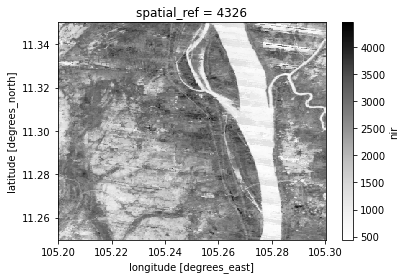

In [17]:
median_composite.nir.plot(cmap = "Greys")

(<Figure size 720x720 with 1 Axes>,
 <AxesSubplot:xlabel='longitude', ylabel='latitude'>)

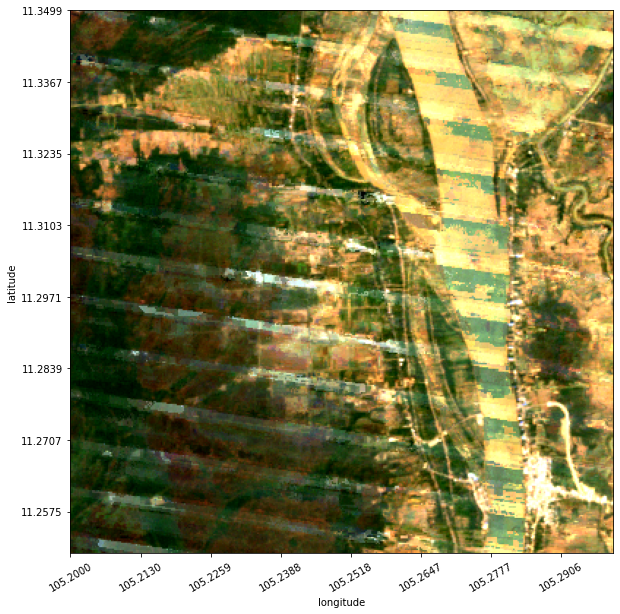

In [18]:
from utils.data_cube_utilities.dc_rgb import rgb
rgb(median_composite)

# Fractional Cover  

Fractional Cover (FC) is used for landcover type estimation (vegetation, non-green vegetation, bare soil) of each pixel. We use a model from CSIRO (Juan Gerschmann) and apply it to a median mosaic.  

In [19]:
from utils.data_cube_utilities.dc_fractional_coverage_classifier import frac_coverage_classify 
frac_classes = frac_coverage_classify(median_composite, clean_mask = np.ones(median_composite.pixel_qa.shape).astype(np.bool)) 

## Plotting Fractional Cover Results
Plot Bare Soil (bs), Photosynthetic Vegetation (pv) or Non Photosynthetic Vegetation (npv)
<br>
Plot a False Color RGB result where RGB = bs/pv/npv.

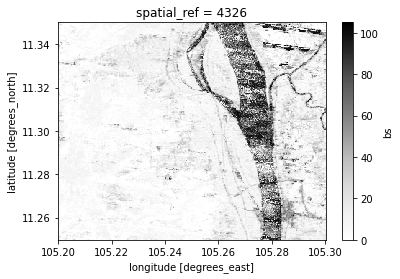

In [20]:
frac_classes.bs.plot(cmap = "Greys")
#frac_classes.pv.plot(cmap = "Greys")
#frac_classes.npv.plot(cmap = "Greys")

(<Figure size 720x720 with 1 Axes>,
 <AxesSubplot:xlabel='longitude', ylabel='latitude'>)

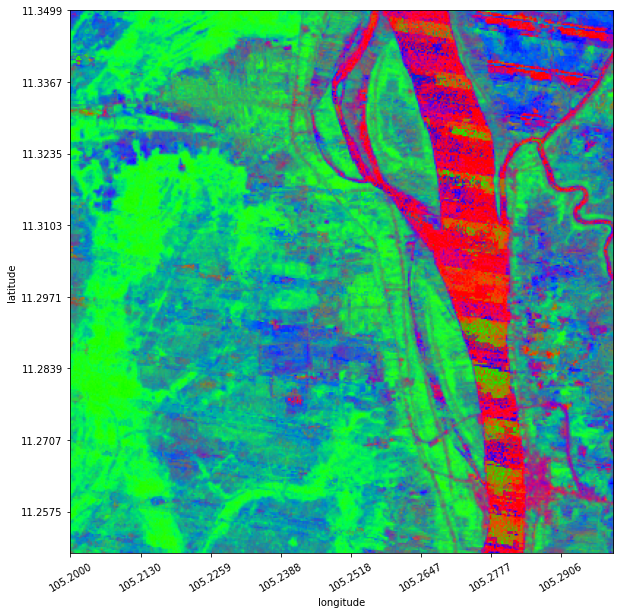

In [21]:
rgb(frac_classes, bands = ['bs', 'pv', 'npv']) 

# Spectral Indices
NDVI (vegetation) and NDBI (urbanization)

### NDVI = Normalized Difference Vegetation Index
A derived index that correlates well with the existance of vegetation.  

$$ NDVI =  \frac{(NIR - RED)}{(NIR + RED)}$$  

In [22]:
def NDVI(dataset):
    return (dataset.nir - dataset.red)/(dataset.nir + dataset.red)

### NDBI = Normalized Difference Build-Up Index 
A derived index that correlates well with the existance of urbanization.  
<br>
  
$$NDBI =  \frac{(SWIR1 - NIR)}{(SWIR1 + NIR)}$$  

In [23]:
def NDBI(dataset):
        return (dataset.swir1 - dataset.nir)/(dataset.swir1 + dataset.nir)

In [24]:
landsat_mosaic = median_mosaic(landsat_dataset)  

ndbi = NDBI(landsat_mosaic)  # Urbanization - Reds
ndvi_mosaic = NDVI(landsat_mosaic)  # Dense Vegetation - Greens

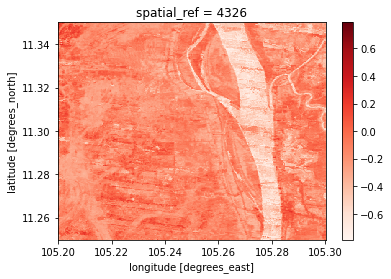

In [25]:
(ndbi).plot(cmap = "Reds")

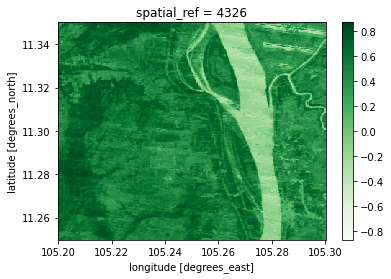

In [26]:
(ndvi_mosaic).plot(cmap = "Greens")

## Create a threshold plot
First we will define a minimum threshold and a maximum threshold. Then you will create a plot that colors the region between the threshold a single color (e.g. red) and the region outside the threshold will be BLACK or WHITE. Also, we will calculate the % of pixels and the number of pixels in the threshold range.

In [27]:
# Select the time slice for the NVDI output (first slice=0)
t = 0
ndvi_dataset_at_time_t = NDVI(landsat_dataset).isel(time = t)  
mask_at_time_t = generate_cloud_mask(landsat_dataset.isel(time = t))

In [28]:
# Define the threshold region bounds
minimum_threshold = 0.6
maximum_threshold = 0.9

In [29]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

def threshold_plot(da, min_threshold, max_threshold, mask = None, width = 10, *args, **kwargs): 
    color_in    = np.array([255,0,0])
    color_out   = np.array([0,0,0])
    color_cloud = np.array([255,255,255])
    
    array = np.zeros((*da.values.shape, 3)).astype(np.int16)
    
    inside  = np.logical_and(da.values > min_threshold, da.values < max_threshold)
    outside = np.invert(inside)
    masked  = np.zeros(da.values.shape).astype(bool) if mask is None else mask
    
    array[inside] =  color_in
    array[outside] = color_out
    array[masked] =  color_cloud

    def figure_ratio(ds, fixed_width = 10):
        width = fixed_width
        height = len(ds.latitude) * (fixed_width / len(ds.longitude))
        return (width, height)


    fig, ax = plt.subplots(figsize = figure_ratio(da,fixed_width = width))
    
    lat_formatter = FuncFormatter(lambda y_val, tick_pos: "{0:.3f}".format(da.latitude.values[tick_pos] ))
    lon_formatter = FuncFormatter(lambda x_val, tick_pos: "{0:.3f}".format(da.longitude.values[tick_pos]))

    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    
    plt.title("Threshold: {} < x < {}".format(min_threshold, max_threshold))
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    plt.imshow(array, *args, **kwargs)
    plt.show()

### Plot NDVI Mosaic

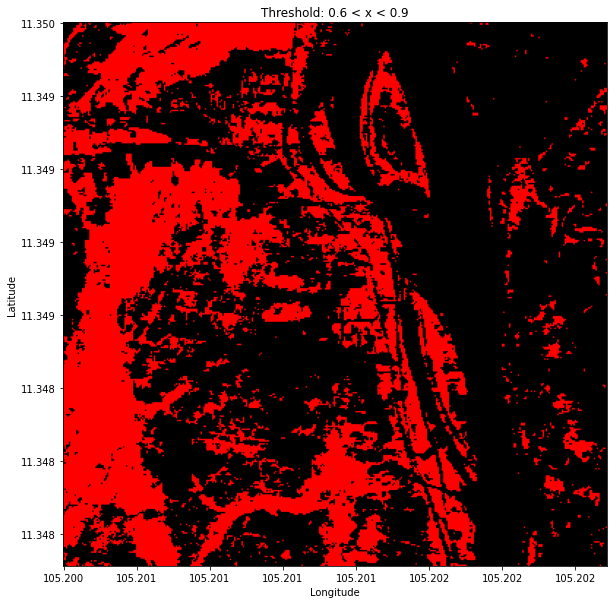

In [30]:
# Plot the NDVI threshold product using a cloud-filterd mosaic
threshold_plot(ndvi_mosaic, minimum_threshold, maximum_threshold, width = 10)

### Plot NDVI at time t

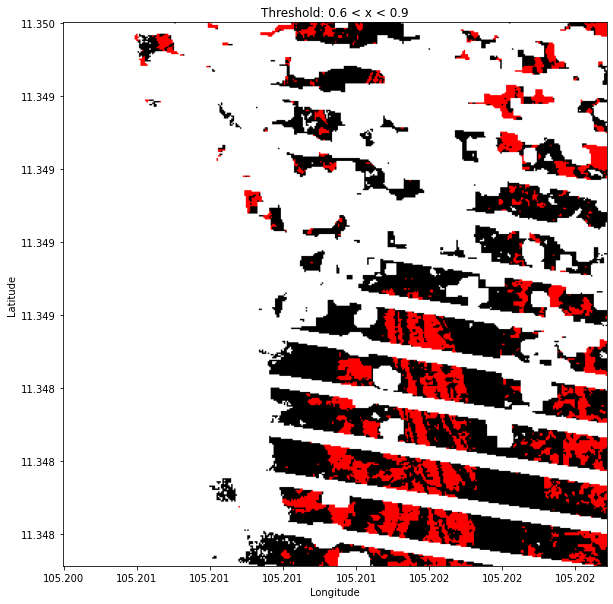

In [31]:
# Plot the NDVI threshold product using a single time slice (one scene)
threshold_plot(ndvi_dataset_at_time_t, minimum_threshold, maximum_threshold, width = 10, mask = mask_at_time_t,)

In [32]:
def threshold_count(da, min_threshold, max_threshold, mask = None):
    def count_not_nans(arr):
        return np.count_nonzero(~np.isnan(arr))
    
    in_threshold = np.logical_and( da.values > min_threshold, da.values < max_threshold)
    
    total_non_cloudy = count_not_nans(da.values) if mask is None else np.sum(mask) 
    
    return dict(total = np.size(da.values),
                total_non_cloudy = total_non_cloudy,
                inside = np.nansum(in_threshold),
                outside = total_non_cloudy - np.nansum(in_threshold)
               )    
    
def threshold_percentage(da, min_threshold, max_threshold, mask = None):
    counts = threshold_count(da, min_threshold, max_threshold, mask = mask)
    return dict(percent_inside_threshold = (counts["inside"]   / counts["total"]) * 100.0,
                percent_outside_threshold = (counts["outside"] / counts["total"]) * 100.0,
                percent_clouds = ( 100.0-counts["total_non_cloudy"] / counts["total"] * 100.0))


In [33]:
threshold_count(ndvi_mosaic,
                minimum_threshold,
                maximum_threshold)

{'total': 138384,
 'total_non_cloudy': 138384,
 'inside': 44355,
 'outside': 94029}

In [34]:
threshold_percentage(ndvi_mosaic,
                     minimum_threshold,
                     maximum_threshold)

{'percent_inside_threshold': 32.05211585154353,
 'percent_outside_threshold': 67.94788414845647,
 'percent_clouds': 0.0}

In [35]:
threshold_count(ndvi_dataset_at_time_t,
                minimum_threshold,
                maximum_threshold,
                mask = mask_at_time_t)

{'total': 138384,
 'total_non_cloudy': 100741,
 'inside': 13591,
 'outside': 87150}

In [36]:
threshold_percentage(ndvi_dataset_at_time_t,
                     minimum_threshold,
                     maximum_threshold,
                     mask = mask_at_time_t )

{'percent_inside_threshold': 9.821222106601919,
 'percent_outside_threshold': 62.97693374956642,
 'percent_clouds': 27.20184414383165}

## Select a single pixel and plot an index value over time

In [37]:
pixel_lat = 11.45
pixel_lon = 105.40

In [38]:
pixel = NDVI(remove_clouds(landsat_dataset)).sel(latitude  = pixel_lat,
                                                longitude = pixel_lon,
                                                method = 'nearest') # nearest neighbor selection  

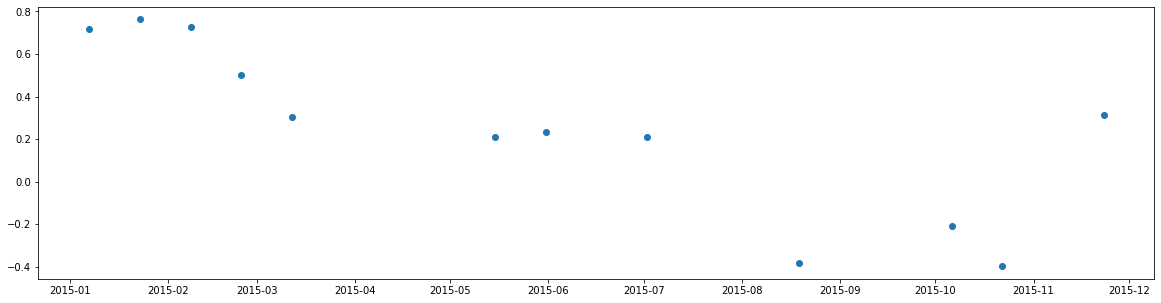

In [39]:
plt.figure(figsize = (20,5)) 
plt.scatter(pixel.time.values, pixel.values)